# Fast Solar Image Classifier using Convolutional Neural Networks

### Final Capstone Project by Deepthi Gopalakrishna Kanchodu


## **Introduction**

The Sun is a highly dynamic star and the only star that we can observe in great detail in different wavelengths thanks to the advanced telescopes. It is now well known that big solar events such as flares, Coronal Mass Ejections, etc., connected to the magnetic activity on the Sun, can modulate the space weather and affect our communication satellites affecting the life on Earth.
    To gain the ability to understand the magnetic phenomena on the Sun and predict the solar events, different instruments such as the ones on-board Solar Dynamics Observatory, Hinode/Solar Optical Telescope, and the newly introduced  Daniel K. Inouye Solar Telescope are recording petabytes of data with high temporal and spatial resolution. 
## **Context**
Fast automated detection and cataloging of solar magnetic features from such vast recorded data will thus help the researchers immensely in investigating the origin of disruptive solar events. Convolutional Neural Networks (CNNs) are highly efficient deep learning models that can ingest a large amount of complex data such as images, videos and automatically discover relevant feature to fit the target. CNNs sometimes costly to train, they often outperform conventional image processing approaches with faster inference and better generalization.


## **Research Question**
(1) Building and training a Convolutional Neural Network (CNN) based fast solar image classifier using labeled images of the solar magnetic features. 

(2) Visualising the feature embedding acquired from the deeper layers of the trained CNN and using saliency analysis to interpret the classification results.


##**Dataset**
The Original publicly available labeled dataset from Hinode/Solar Optical Telescope is accquired from https://github.com/bionictoucan/Slic/releases/tag/1.1.1

**Dataset Content**
*   Images from Solar Optical Telescope representing 5 varieties of solar magnetic features: 'filaments', 'flares', 'prominences', 'quiet', 'sunspots'
*   Each image is attributed to one among 5 features
*   Training set contains 11857 (flattened) images of size 256x256 with corresponding labels
*   Test set contains 1318 (flattened) images of size 256x256 with corresponding labels

## **Methodology**
* Data preparation
* Building the CNN architecture
* Training the CNN and tuning its hyper-parameters to pick the best trained model
* Inference on test set and error analysis through confusion matrix
* Visualising the feature embedding through PCA and tSNE in 2D and 3D to understand class separability
* Interpreting the model inference through saliency analysis


## **Import Libraries**

In [1]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf
from vis.utils import utils
import keras
from keras import activations
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import matplotlib.pyplot as plt
import numpy as np
import pickle
tf.compat.v1.disable_eager_execution()
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Data Import, Preparation and Visualization**

In [2]:
train_data = np.load('/content/drive/MyDrive/python_for_data_scientists/capstones/capstone_final/solar_train_data.npz')
test_data = np.load('/content/drive/MyDrive/python_for_data_scientists/capstones/capstone_final/solar_test_data.npz')

Text(0.5, 1.0, 'Test Set')

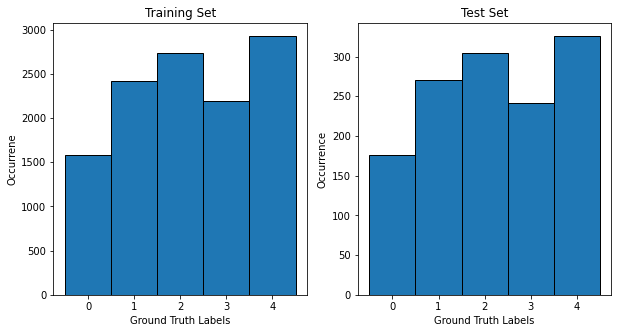

In [3]:
##distribution of training and test set ground truth labels to cleck for any major class imbalance
mat = train_data['data']
matt = test_data['data']
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(mat[:,0],bins=[-0.5,0.5,1.5,2.5,3.5,4.5],ec='k')
plt.xlabel('Ground Truth Labels')
plt.ylabel('Occurrene')
plt.title('Training Set')
plt.subplot(1,2,2)
plt.hist(matt[:,0],bins=[-0.5,0.5,1.5,2.5,3.5,4.5],ec='k')
plt.xlabel('Ground Truth Labels')
plt.ylabel('Occurrence')
plt.title('Test Set')

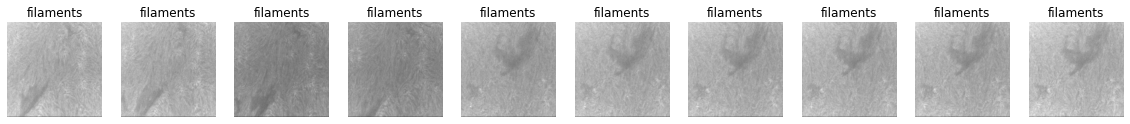

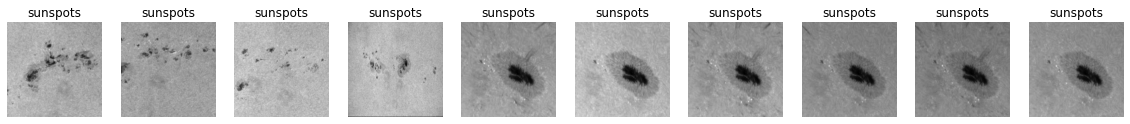

In [4]:
### Reshaping the flattened images and visualizinf them
classes = ['filaments', 'flares', 'prominences', 'quiet', 'sunspots']
n = 0   ###class index
plt.figure(figsize=(20,2)) ###plot a few images of classes[n] from training set
for i in range(10):
  ax = plt.subplot(1,10,i+1)
  ind = np.where(mat[:,0]==n)[0][15*i] ### every 15th image of label n
  plt.imshow(np.reshape(mat[ind,1:], (-1, 256)),cmap='gray',vmin=0,vmax=255) ### reshaping the images for visualization
  plt.axis('off')
  plt.title(classes[n])

n = 4
plt.figure(figsize=(20,2)) ###plot a few images of classes[n] from test set
for i in range(10):
  ax = plt.subplot(1,10,i+1)
  ind = np.where(mat[:,0]==n)[0][15*i]
  plt.imshow(np.reshape(mat[ind,1:], (-1, 256)),cmap='gray',vmin=0,vmax=255)
  plt.axis('off')
  plt.title(classes[n])

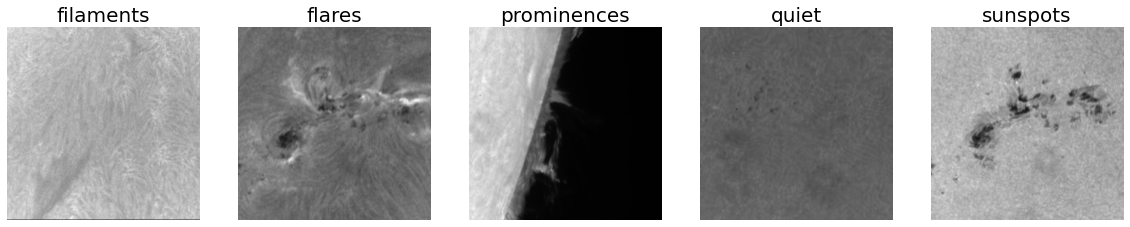

In [7]:
plt.figure(figsize=(20,4))
for n in range(5):
  plt.subplot(1,5,n+1)
  ind = np.where(mat[:,0]==n)[0][0]
  plt.imshow(np.reshape(mat[ind,1:], (-1, 256)),cmap='gray',vmin=0,vmax=255) ### reshaping the images for visualization
  plt.axis('off')
  plt.title(classes[n],fontsize=20)



In [ ]:
### data normalization and one hot encoding of the target
import cv2
x_train = np.zeros((mat.shape[0],64,64,1),dtype='float')
x_test = np.zeros((matt.shape[0],64,64,1),dtype='float')
y_train = np.zeros((mat.shape[0],5),dtype='float')
y_test = np.zeros((matt.shape[0],5),dtype='float')
k = 0

for i in range(mat.shape[0]):
    x_train[i,:,:,0] = cv2.resize(np.reshape(mat[i,1:], (-1, 256)),(64,64)).astype(float)/255 #normalization, resizing to consume less memory
    y_train[i,mat[i,0]] = 1.0 #one-hot encoding

for i in range(matt.shape[0]):
    x_test[i,:,:,0] = cv2.resize(np.reshape(matt[i,1:], (-1, 256)),(64,64)).astype(float)/255
    y_test[i,matt[i,0]] = 1.0

## **Building,training and tuning a CNN**
*   Convolutional Neural Net architecture --- input: 64x64 images, output: one-hot encoded class i.e. class 'sunspot' ~ [0,0,0,0,1]
*   Activation used for tuning 
*   Catergorical cross entropy loss
*   Batch size used for tuning
*   SGD optimizer
*   Learning rate used for tuning






### **Defining model architecture**

In [ ]:
##model architecture
def CNN_model(activation = 'relu'):
  in1 = Input(shape=(64, 64, 1))  ### 64x64 images as input
  x = Conv2D(64, (3, 3),padding='same')(in1)  ###convolve each image with 3x3 filters and break into 64 feature layers
  x = BatchNormalization()(x)  ### standardise the feature layers
  x = Activation(activation)(x)  ### apply non-linearity
  x = MaxPooling2D(pool_size =(2, 2), strides=(2,2))(x) ### break layers into 2x2 block and calculate max for each block
  x = Conv2D(128, (3, 3),padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)
  x = MaxPooling2D(pool_size =(2, 2), strides=(2,2))(x)
  x = Conv2D(256, (3, 3),padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)
  x = MaxPooling2D(pool_size =(2, 2), strides=(2,2))(x)
  x = Conv2D(512, (3, 3),padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)
  x = MaxPooling2D(pool_size =(2, 2), strides=(2,2))(x)
  x = Flatten()(x)
  x = Dense(256)(x) 
  x = Activation(activation)(x)
  x = Dropout(0.5)(x) 
  x = Dense(256,name='tSNE-layer')(x) 
  x = Activation(activation)(x)
  x = Dropout(0.5)(x) 
  out = Dense(5, activation='softmax', name='visualized_layer')(x)
  model = Model(inputs=[in1], outputs=[out])
  return model

Instructions for updating:
Colocations handled automatically by placer.


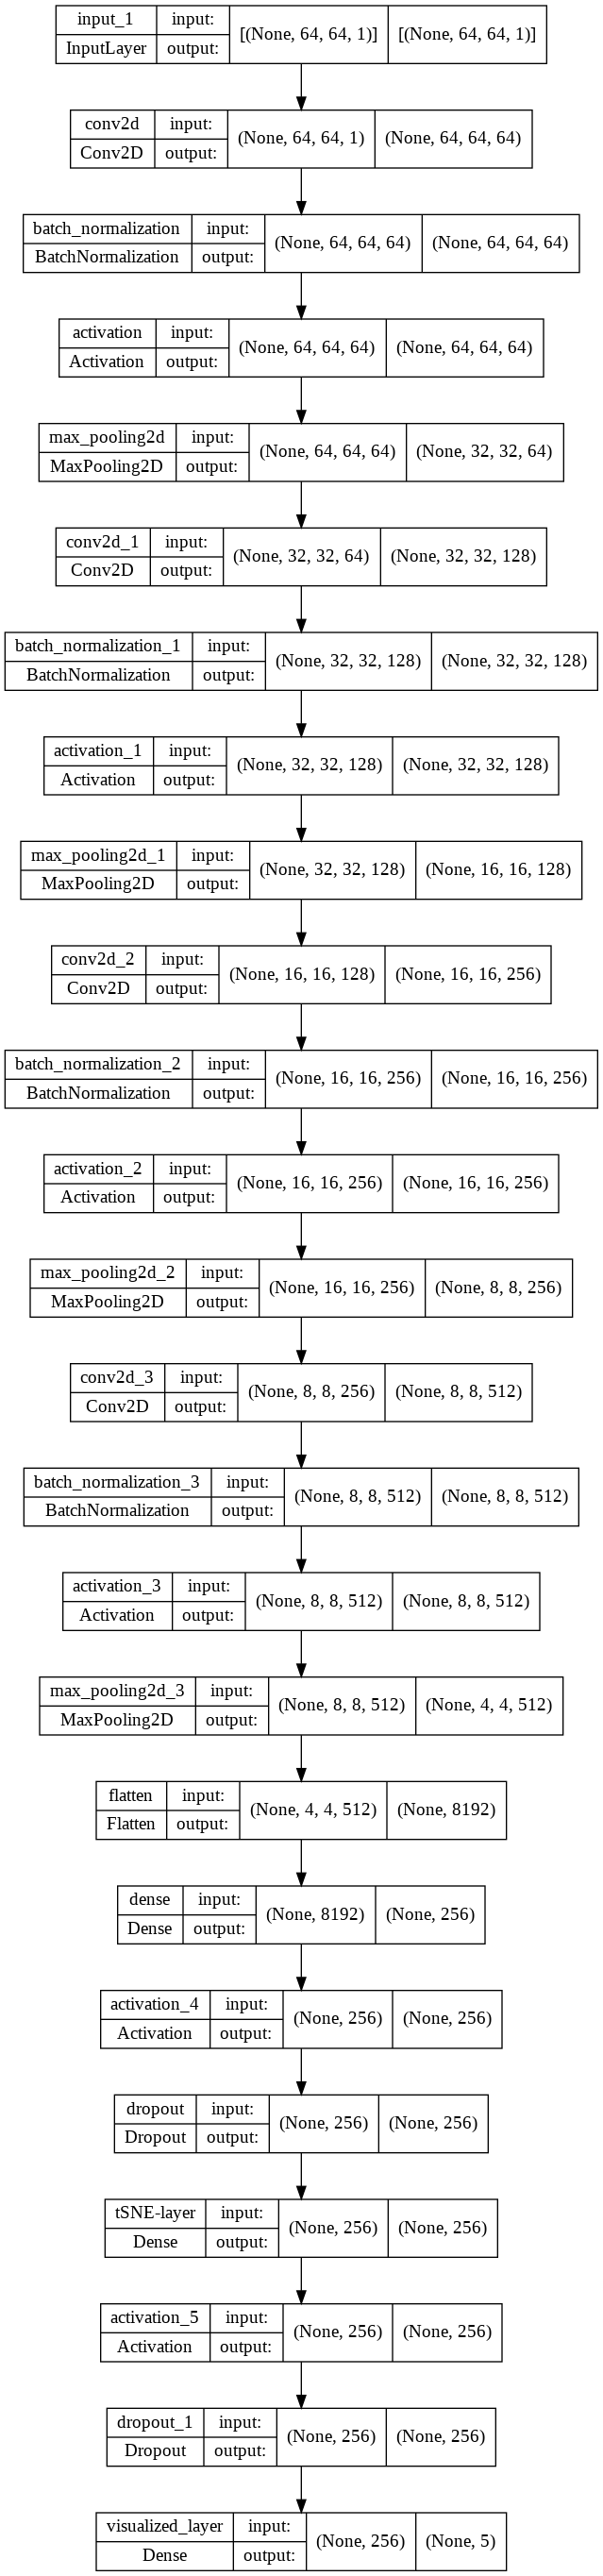

In [ ]:
###visualize the model architecture
from keras.utils.vis_utils import plot_model
model = CNN_model(activation = 'relu')
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
###get an estimate of trainable and non-trainable model parameters
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856 

### **Defining function for image augmentation to increase divesity during training**

In [ ]:
###define a function for image augmentation
def flip_random(image):
    # With random horizontal and vertical flipping.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

### **Model training and tuning**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import pickle
AUTO = tf.data.AUTOTUNE
###total number of epochs, in each epoch model sees the entire training data divided into non-overlapping batches
EPOCHS = 10
###starting epoch - 1
ie = 0

for BATCH_SIZE in [8,16,32]: #tuning
  for nlin in ['relu','elu']: #tuning
    for lr in [0.0001,0.0005,0.001]: #tuning
      train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
      test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
      # Shuffle, batch, and prefetch this dataset for performance with random flips as augmentation
      train_ds = (
          train_ds.shuffle(3072)
          .map(lambda x, y: (flip_random(x), y), num_parallel_calls=AUTO)
          .batch(BATCH_SIZE)
          .prefetch(AUTO)
      )
      test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)
      model = CNN_model(activation = nlin)
      ###compile the model
      sgd = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
      model.compile(loss ='categorical_crossentropy',  optimizer = sgd, metrics =['accuracy']) 
      ###fit the model with checkpoints
      path = '/content/drive/MyDrive/python_for_data_scientists/capstones/capstone_final/'
      from keras.callbacks import ModelCheckpoint, EarlyStopping
      checkpoint = ModelCheckpoint(path+"solar_image_multi_class_model_"+str(BATCH_SIZE)+"_"+str(lr)+"_"+nlin+".h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
      early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
      history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, initial_epoch = ie,callbacks=[checkpoint,early_stopping])
      pickle.dump(history.history['accuracy'],open(path+'accuracy_'+str(BATCH_SIZE)+'_'+str(lr)+'_'+nlin+'.p','wb'))
      pickle.dump(history.history['val_accuracy'],open(path+'val_accuracy_'+str(BATCH_SIZE)+'_'+str(lr)+'_'+nlin+'.p','wb'))
      ###evaluate test accuracy
      _, test_acc = model.evaluate(test_ds)
      print("Test accuracy: {:.2f}%".format(test_acc * 100))

Train on 371 steps, validate on 42 steps
Epoch 1/10
371/371 [==============================] - ETA: 0s - batch: 185.0000 - size: 1.0000 - loss: 0.3834 - accuracy: 0.8854

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_accuracy improved from -inf to 0.18741, saving model to /content/drive/MyDrive/python_for_data_scientists/capstones/capstone_final/solar_image_multi_class_model_32_0.0001_elu.h5
371/371 [==============================] - 68s 181ms/step - batch: 185.0000 - size: 1.0000 - loss: 0.3834 - accuracy: 0.8854 - val_loss: 2.8199 - val_accuracy: 0.1874
Epoch 2/10
371/371 [==============================] - ETA: 0s - batch: 185.0000 - size: 1.0000 - loss: 0.2236 - accuracy: 0.9238
Epoch 2: val_accuracy improved from 0.18741 to 0.87709, saving model to /content/drive/MyDrive/python_for_data_scientists/capstones/capstone_final/solar_image_multi_class_model_32_0.0001_elu.h5
371/371 [==============================] - 70s 189ms/step - batch: 185.0000 - size: 1.0000 - loss: 0.2236 - accuracy: 0.9238 - val_loss: 0.3270 - val_accuracy: 0.8771
Epoch 3/10
371/371 [==============================] - ETA: 0s - batch: 185.0000 - size: 1.0000 - loss: 0.1797 - accuracy: 0.9393
Epoch 3: val_accuracy 

### **Picking the best model through hyperparameter tuning**

In [ ]:
import pandas as pd
df = {'Activation':[],'Learning Rate':[],'Batch Size':[],'Validation Accuracy':[]}
for BATCH_SIZE in [8,16,32]:
  for nlin in ['relu','elu']:
    for lr in [0.0001,0.0005,0.001]:
      val_acc = pickle.load(open(path+'val_accuracy_'+str(BATCH_SIZE)+'_'+str(lr)+'_'+nlin+'.p','rb'))
      df['Activation'].append(nlin)
      df['Batch Size'].append(BATCH_SIZE)
      df['Learning Rate'].append(lr)
      df['Validation Accuracy'].append(np.max(val_acc))

df = pd.DataFrame(df)
df.head(18)
df.to_csv(path+'Model_performance_tuning.csv')

In [ ]:
activation_opt = list(df['Activation'][df['Validation Accuracy']==df['Validation Accuracy'].max()])[0]
batch_size_opt = list(df['Batch Size'][df['Validation Accuracy']==df['Validation Accuracy'].max()])[0]
learning_rate_opt = list(df['Learning Rate'][df['Validation Accuracy']==df['Validation Accuracy'].max()])[0]
print('optimal activation : {}'.format(activation_opt))
print('optimal batch size : {}'.format(batch_size_opt))
print('optimal learning rate : {}'.format(learning_rate_opt))

optimal activation : elu
optimal batch size : 8
optimal learning rate : 0.001


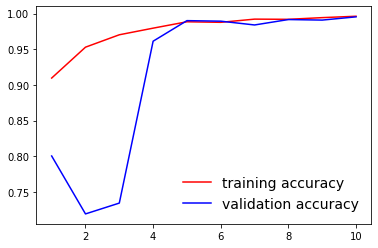

In [ ]:
acc = pickle.load(open(path+'accuracy_'+str(batch_size_opt)+'_'+str(learning_rate_opt)+'_'+activation_opt+'.p','rb'))
val_acc = pickle.load(open(path+'val_accuracy_'+str(batch_size_opt)+'_'+str(learning_rate_opt)+'_'+activation_opt+'.p','rb'))
epochs = np.linspace(1,10,10)
plt.plot(epochs,acc,'-r',label = 'training accuracy')
plt.plot(epochs,val_acc,'-b',label = 'validation accuracy')
plt.legend(frameon = False,fontsize=14)

In [ ]:
###load the best model
model = CNN_model(activation=activation_opt)
model.load_weights(path+"solar_image_multi_class_model_"+str(batch_size_opt)+'_'+str(learning_rate_opt)+'_'+activation_opt+".h5")

# **Evaluating the model**


*   Error Analysis: Confusion matrix
*   Feature visualisation: PCA and t-SNE



### **Model inference on entire test set**

In [ ]:
###predict outcome for entire test set
import time
start_time = time.perf_counter ()
p = model.predict(x_test)
end_time = time.perf_counter ()
print((end_time - start_time)/1318, "seconds per inference")

0.0012269098133539723 seconds per inference


In [ ]:
len(p)

1318

### **Visualizing model ineference on representative test set image**

[176 270 304 242 326]
target class: sunspots
predicted class: sunspots


([0, 1, 2, 3, 4], <a list of 5 Text major ticklabel objects>)

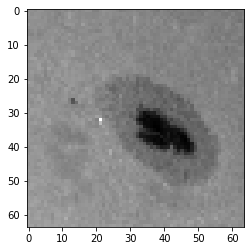

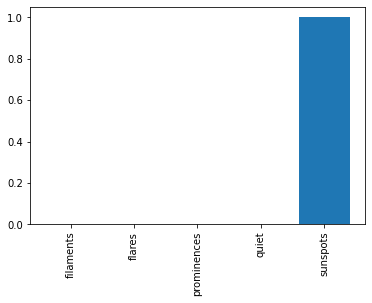

In [ ]:
###prediction on a single image
plt.figure(figsize=(4,4))
classes = ['filaments', 'flares', 'prominences', 'quiet', 'sunspots']
b = np.linspace(-1,4,6)+0.5
h,_ = np.histogram(matt[:,0],bins = b)
print(h)
n = 4
img = 40
nn = np.where(matt[:,0]==n)[0][np.min([img,h[n]-1])]
plt.imshow(x_test[nn,:,:,0],cmap='gray')
print("target class: "+classes[np.argmax(y_test[nn])])
print("predicted class: "+classes[np.argmax(p[nn])])
plt.figure()
plt.bar(classes,p[nn])
plt.xticks(rotation = 90)

### **Generating and visualizing Confusion Matrix**

In [ ]:
##evaluate the class-wise mistakes in prediction: confusion matrix
from sklearn.metrics import confusion_matrix
tt = []
pp = []
for i in range(len(y_test)):
  tt.append(classes[np.argmax(y_test[i])])
  pp.append(classes[np.argmax(p[i])])
print(confusion_matrix(tt, pp))

[[172   0   0   4   0]
 [  0 268   1   0   1]
 [  0   0 304   0   0]
 [  0   0   0 242   0]
 [  0   0   0   0 326]]


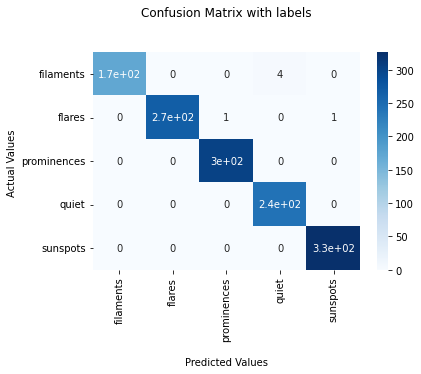

In [ ]:
##visualize the confusion matrix
import seaborn as sns
cf_matrix = confusion_matrix(tt, pp)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.set_xticklabels(classes,rotation = 90)
ax.set_yticklabels(classes,rotation = 0)

## Display the visualization of the Confusion Matrix.
plt.show()

### **Visualising 256-dimensional feature embedding in 2D and 3D**

In [ ]:
###make a sub-model that ouputs a feature embedding of size 256
model_tSNE = Model(model.input,model.get_layer('tSNE-layer').output)

In [ ]:
###predict feature embedding for entire test set
p1 = model_tSNE.predict(x_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
print(len(p1))
print(len(p1[0]))

1318
256


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



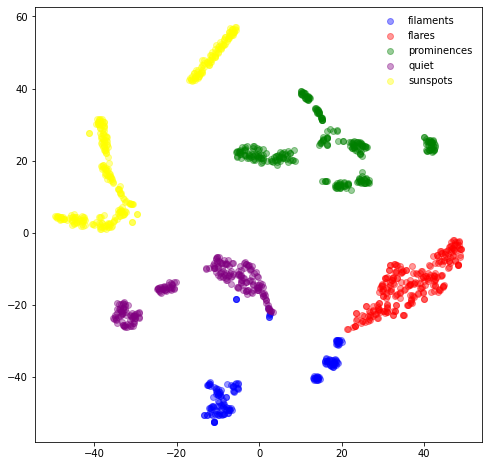

In [ ]:
###compactifying 256-dimensional feature space into 2-dimensional space using t-SNE
intermediates = []
class_intermediates = []
color_intermediates = []
colors = ['b','r','g','purple','yellow']
for i in range(len(x_test)):
    output_class = np.argmax(y_test[i,:])
    intermediate_tensor = p1[i]
    intermediates.append(intermediate_tensor)
    color_intermediates.append(colors[output_class])
    class_intermediates.append(classes[output_class])

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
intermediates_tsne = tsne.fit_transform(intermediates)

plt.figure(figsize=(8, 8))
classes = ['filaments', 'flares', 'prominences', 'quiet', 'sunspots']
for i in range(5):
  idx = np.where(matt[:,0]==i)[0]
  plt.scatter(x = intermediates_tsne[idx,0], y=intermediates_tsne[idx,1], color=colors[i],label=classes[i],alpha=0.4)
plt.legend(frameon = False)
plt.show()



In [ ]:
###compactifying 256-dimensional feature space into 3-dimensional space using t-SNE
import plotly.express as px
tsne = TSNE(n_components=3, random_state=0)
intermediates_tsne3 = tsne.fit_transform(intermediates)
df = {}
df['comp1'] = intermediates_tsne3[:,0]
df['comp2'] = intermediates_tsne3[:,1]
df['comp3'] = intermediates_tsne3[:,2]
df['class'] = class_intermediates
fig = px.scatter_3d(df, x='comp1', y='comp2', z='comp3',
              color='class')
fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
###compactifying 256-dimensional feature space into 3-dimensional space using PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(intermediates)

pca = PCA(n_components=3, random_state=0)
intermediates_pca3 = pca.fit_transform(scaler.transform(intermediates))
df = {}
df['comp1'] = intermediates_pca3[:,0]
df['comp2'] = intermediates_pca3[:,1]
df['comp3'] = intermediates_pca3[:,2]
df['class'] = class_intermediates
fig = px.scatter_3d(df, x='comp1', y='comp2', z='comp3',
              color='class')
fig.show()

### **What if Deep Learning Model was not there?** 

Visualising feature space in 2D and 3D treating each image pixel as a feature

In [ ]:
###compactifying 64x64 images into 3-dimensional space using t-SNE
intermediates_raw = []
color_intermediates = []
class_intermediates = []
colors = ['b','r','g','purple','yellow']
for i in range(len(x_test)):
    output_class = np.argmax(y_test[i,:])
    intermediates_raw.append(list(np.reshape(x_test[i,:,:,0],(4096))))
    color_intermediates.append(colors[output_class])
    class_intermediates.append(classes[output_class])

tsne = TSNE(n_components=3, random_state=0)
intermediates_tsne_r3 = tsne.fit_transform(intermediates_raw)
df = {}
df['comp1'] = intermediates_tsne_r3[:,0]
df['comp2'] = intermediates_tsne_r3[:,1]
df['comp3'] = intermediates_tsne_r3[:,2]
df['class'] = class_intermediates
fig = px.scatter_3d(df, x='comp1', y='comp2', z='comp3',
              color='class')
fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
###compactifying 64x64 images into 3-dimensional space using PCA
scaler = StandardScaler()
scaler.fit(intermediates_raw)
pca = PCA(n_components=3, random_state=0)
intermediates_pca_r3 = pca.fit_transform(scaler.transform(intermediates_raw))
df = {}
df['comp1'] = intermediates_pca_r3[:,0]
df['comp2'] = intermediates_pca_r3[:,1]
df['comp3'] = intermediates_pca_r3[:,2]
df['class'] = class_intermediates
fig = px.scatter_3d(df, x='comp1', y='comp2', z='comp3',
              color='class')
fig.show()

# **Beyond the black-box Deep Learning model : Interpretability with Saliency maps**

### **Installing keras-vis and editing saliency.py to update the imports**

In [ ]:
!pip install https://github.com/raghakot/keras-vis/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     \ 45.5 MB 167.0 MB/s
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30868 sha256=a46d49cb467f86557592193752885808238e80b3a699b34b18129591a281066e
  Stored in directory: /tmp/pip-ephem-wheel-cache-hsg4spa8/wheels/86/18/04/ffe2ca1aa9fedc1e1b11a85372ad6c5ba2b4f25592d704737b
Successfully built keras-vis
  Attempting uninstall: keras-vis
    Found existing installation: keras-vis 0.4.1
    Uninstalling keras-vis-0.4.1:
      Successfully uninstalled keras-vis-0.4.1


In [ ]:
#view saliency.py and copy
%pycat /usr/local/lib/python3.7/dist-packages/vis/visualization/saliency.py

In [ ]:
#remove saliency.py
!rm /usr/local/lib/python3.7/dist-packages/vis/visualization/saliency.py

In [ ]:
#write sliency.py with updated imports 
%%writefile /usr/local/lib/python3.7/dist-packages/vis/visualization/saliency.py
from __future__ import absolute_import

import numpy as np
from scipy.ndimage.interpolation import zoom

from keras.layers.convolutional import Conv2D
from keras.layers.pooling import Pooling1D, Pooling2D, Pooling3D
from keras.layers.wrappers import Wrapper
from keras import backend as K

from ..losses import ActivationMaximization
from ..optimizer import Optimizer
from ..backprop_modifiers import get
from ..utils import utils


def _find_penultimate_layer(model, layer_idx, penultimate_layer_idx):
    """Searches for the nearest penultimate `Conv` or `Pooling` layer.

    Args:
        model: The `keras.models.Model` instance.
        layer_idx: The layer index within `model.layers`.
        penultimate_layer_idx: The pre-layer to `layer_idx`. If set to None, the nearest penultimate
            `Conv` or `Pooling` layer is used.

    Returns:
        The penultimate layer.
    """
    if penultimate_layer_idx is None:
        for idx, layer in utils.reverse_enumerate(model.layers[:layer_idx - 1]):
            if isinstance(layer, Wrapper):
                layer = layer.layer
            if isinstance(layer, (Conv2D, Pooling1D, Pooling2D, Pooling3D)):
                penultimate_layer_idx = idx
                break

    if penultimate_layer_idx is None:
        raise ValueError('Unable to determine penultimate `Conv` or `Pooling` '
                         'layer for layer_idx: {}'.format(layer_idx))

    # Handle negative indexing otherwise the next check can fail.
    if layer_idx < 0:
        layer_idx = len(model.layers) + layer_idx
    if penultimate_layer_idx > layer_idx:
        raise ValueError('`penultimate_layer_idx` needs to be before `layer_idx`')

    return model.layers[penultimate_layer_idx]


def visualize_saliency_with_losses(input_tensor, losses, seed_input, wrt_tensor=None, grad_modifier='absolute', keepdims=False):
    """Generates an attention heatmap over the `seed_input` by using positive gradients of `input_tensor`
    with respect to weighted `losses`.

    This function is intended for advanced use cases where a custom loss is desired. For common use cases,
    refer to `visualize_class_saliency` or `visualize_regression_saliency`.

    For a full description of saliency, see the paper:
    [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps]
    (https://arxiv.org/pdf/1312.6034v2.pdf)

    Args:
        input_tensor: An input tensor of shape: `(samples, channels, image_dims...)` if `image_data_format=
            channels_first` or `(samples, image_dims..., channels)` if `image_data_format=channels_last`.
        losses: List of ([Loss](vis.losses.md#Loss), weight) tuples.
        seed_input: The model input for which activation map needs to be visualized.
        wrt_tensor: Short for, with respect to. The gradients of losses are computed with respect to this tensor.
            When None, this is assumed to be the same as `input_tensor` (Default value: None)
        grad_modifier: gradient modifier to use. See [grad_modifiers](vis.grad_modifiers.md). By default `absolute`
            value of gradients are used. To visualize positive or negative gradients, use `relu` and `negate`
            respectively. (Default value = 'absolute')
        keepdims: A boolean, whether to keep the dimensions or not.
            If keepdims is False, the channels axis is deleted.
            If keepdims is True, the grad with same shape as input_tensor is returned. (Default value: False)

    Returns:
        The normalized gradients of `seed_input` with respect to weighted `losses`.
    """
    opt = Optimizer(input_tensor, losses, wrt_tensor=wrt_tensor, norm_grads=False)
    grads = opt.minimize(seed_input=seed_input, max_iter=1, grad_modifier=grad_modifier, verbose=False)[1]

    if not keepdims:
        channel_idx = 1 if K.image_data_format() == 'channels_first' else -1
        grads = np.max(grads, axis=channel_idx)
    return utils.normalize(grads)[0]


def visualize_saliency(model, layer_idx, filter_indices, seed_input, wrt_tensor=None,
                       backprop_modifier=None, grad_modifier='absolute', keepdims=False):
    """Generates an attention heatmap over the `seed_input` for maximizing `filter_indices`
    output in the given `layer_idx`.

    Args:
        model: The `keras.models.Model` instance. The model input shape must be: `(samples, channels, image_dims...)`
            if `image_data_format=channels_first` or `(samples, image_dims..., channels)` if
            `image_data_format=channels_last`.
        layer_idx: The layer index within `model.layers` whose filters needs to be visualized.
        filter_indices: filter indices within the layer to be maximized.
            If None, all filters are visualized. (Default value = None)
            For `keras.layers.Dense` layer, `filter_idx` is interpreted as the output index.
            If you are visualizing final `keras.layers.Dense` layer, consider switching 'softmax' activation for
            'linear' using [utils.apply_modifications](vis.utils.utils.md#apply_modifications) for better results.
        seed_input: The model input for which activation map needs to be visualized.
        wrt_tensor: Short for, with respect to. The gradients of losses are computed with respect to this tensor.
            When None, this is assumed to be the same as `input_tensor` (Default value: None)
        backprop_modifier: backprop modifier to use. See [backprop_modifiers](vis.backprop_modifiers.md). If you don't
            specify anything, no backprop modification is applied. (Default value = None)
        grad_modifier: gradient modifier to use. See [grad_modifiers](vis.grad_modifiers.md). By default `absolute`
            value of gradients are used. To visualize positive or negative gradients, use `relu` and `negate`
            respectively. (Default value = 'absolute')
        keepdims: A boolean, whether to keep the dimensions or not.
            If keepdims is False, the channels axis is deleted.
            If keepdims is True, the grad with same shape as input_tensor is returned. (Default value: False)

    Example:
        If you wanted to visualize attention over 'bird' category, say output index 22 on the
        final `keras.layers.Dense` layer, then, `filter_indices = [22]`, `layer = dense_layer`.

        One could also set filter indices to more than one value. For example, `filter_indices = [22, 23]` should
        (hopefully) show attention map that corresponds to both 22, 23 output categories.

    Returns:
        The heatmap image indicating the `seed_input` regions whose change would most contribute towards
        maximizing the output of `filter_indices`.
    """
    if backprop_modifier is not None:
        modifier_fn = get(backprop_modifier)
        model = modifier_fn(model)

    # `ActivationMaximization` loss reduces as outputs get large, hence negative gradients indicate the direction
    # for increasing activations. Multiply with -1 so that positive gradients indicate increase instead.
    losses = [
        (ActivationMaximization(model.layers[layer_idx], filter_indices), -1)
    ]
    return visualize_saliency_with_losses(model.input, losses, seed_input, wrt_tensor, grad_modifier, keepdims)


def visualize_cam_with_losses(input_tensor, losses, seed_input, penultimate_layer, grad_modifier=None):
    """Generates a gradient based class activation map (CAM) by using positive gradients of `input_tensor`
    with respect to weighted `losses`.

    For details on grad-CAM, see the paper:
    [Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via Gradient-based Localization]
    (https://arxiv.org/pdf/1610.02391v1.pdf).

    Unlike [class activation mapping](https://arxiv.org/pdf/1512.04150v1.pdf), which requires minor changes to
    network architecture in some instances, grad-CAM has a more general applicability.

    Compared to saliency maps, grad-CAM is class discriminative; i.e., the 'cat' explanation exclusively highlights
    cat regions and not the 'dog' region and vice-versa.

    Args:
        input_tensor: An input tensor of shape: `(samples, channels, image_dims...)` if `image_data_format=
            channels_first` or `(samples, image_dims..., channels)` if `image_data_format=channels_last`.
        losses: List of ([Loss](vis.losses.md#Loss), weight) tuples.
        seed_input: The model input for which activation map needs to be visualized.
        penultimate_layer: The pre-layer to `layer_idx` whose feature maps should be used to compute gradients
            with respect to filter output.
        grad_modifier: gradient modifier to use. See [grad_modifiers](vis.grad_modifiers.md). If you don't
            specify anything, gradients are unchanged (Default value = None)

    Returns:
        The normalized gradients of `seed_input` with respect to weighted `losses`.
    """
    penultimate_output = penultimate_layer.output
    opt = Optimizer(input_tensor, losses, wrt_tensor=penultimate_output, norm_grads=False)
    _, grads, penultimate_output_value = opt.minimize(seed_input, max_iter=1, grad_modifier=grad_modifier, verbose=False)

    # For numerical stability. Very small grad values along with small penultimate_output_value can cause
    # w * penultimate_output_value to zero out, even for reasonable fp precision of float32.
    grads = grads / (np.max(grads) + K.epsilon())

    # Average pooling across all feature maps.
    # This captures the importance of feature map (channel) idx to the output.
    channel_idx = 1 if K.image_data_format() == 'channels_first' else -1
    other_axis = np.delete(np.arange(len(grads.shape)), channel_idx)
    weights = np.mean(grads, axis=tuple(other_axis))

    # Generate heatmap by computing weight * output over feature maps
    output_dims = utils.get_img_shape(penultimate_output_value)[2:]
    heatmap = np.zeros(shape=output_dims, dtype=K.floatx())
    for i, w in enumerate(weights):
        if channel_idx == -1:
            heatmap += w * penultimate_output_value[0, ..., i]
        else:
            heatmap += w * penultimate_output_value[0, i, ...]

    # ReLU thresholding to exclude pattern mismatch information (negative gradients).
    heatmap = np.maximum(heatmap, 0)

    # The penultimate feature map size is definitely smaller than input image.
    input_dims = utils.get_img_shape(input_tensor)[2:]

    # Figure out the zoom factor.
    zoom_factor = [i / (j * 1.0) for i, j in iter(zip(input_dims, output_dims))]
    heatmap = zoom(heatmap, zoom_factor)
    return utils.normalize(heatmap)


def visualize_cam(model, layer_idx, filter_indices,
                  seed_input, penultimate_layer_idx=None,
                  backprop_modifier=None, grad_modifier=None):
    """Generates a gradient based class activation map (grad-CAM) that maximizes the outputs of
    `filter_indices` in `layer_idx`.

    Args:
        model: The `keras.models.Model` instance. The model input shape must be: `(samples, channels, image_dims...)`
            if `image_data_format=channels_first` or `(samples, image_dims..., channels)` if
            `image_data_format=channels_last`.
        layer_idx: The layer index within `model.layers` whose filters needs to be visualized.
        filter_indices: filter indices within the layer to be maximized.
            If None, all filters are visualized. (Default value = None)
            For `keras.layers.Dense` layer, `filter_idx` is interpreted as the output index.
            If you are visualizing final `keras.layers.Dense` layer, consider switching 'softmax' activation for
            'linear' using [utils.apply_modifications](vis.utils.utils.md#apply_modifications) for better results.
        seed_input: The input image for which activation map needs to be visualized.
        penultimate_layer_idx: The pre-layer to `layer_idx` whose feature maps should be used to compute gradients
            wrt filter output. If not provided, it is set to the nearest penultimate `Conv` or `Pooling` layer.
        backprop_modifier: backprop modifier to use. See [backprop_modifiers](vis.backprop_modifiers.md). If you don't
            specify anything, no backprop modification is applied. (Default value = None)
        grad_modifier: gradient modifier to use. See [grad_modifiers](vis.grad_modifiers.md). If you don't
            specify anything, gradients are unchanged (Default value = None)

     Example:
        If you wanted to visualize attention over 'bird' category, say output index 22 on the
        final `keras.layers.Dense` layer, then, `filter_indices = [22]`, `layer = dense_layer`.

        One could also set filter indices to more than one value. For example, `filter_indices = [22, 23]` should
        (hopefully) show attention map that corresponds to both 22, 23 output categories.

    Returns:
        The heatmap image indicating the input regions whose change would most contribute towards
        maximizing the output of `filter_indices`.
    """
    if backprop_modifier is not None:
        modifier_fn = get(backprop_modifier)
        model = modifier_fn(model)

    penultimate_layer = _find_penultimate_layer(model, layer_idx, penultimate_layer_idx)

    # `ActivationMaximization` outputs negative gradient values for increase in activations. Multiply with -1
    # so that positive gradients indicate increase instead.
    losses = [
        (ActivationMaximization(model.layers[layer_idx], filter_indices), -1)
    ]
    return visualize_cam_with_losses(model.input, losses, seed_input, penultimate_layer, grad_modifier)

Writing /usr/local/lib/python3.7/dist-packages/vis/visualization/saliency.py


### **Generating saliency maps**

In [ ]:
from vis.visualization import visualize_saliency

In [ ]:
layer_index = utils.find_layer_idx(model, 'visualized_layer') ###index of the last layer

In [ ]:
# Swap softmax with linear
model.layers[layer_index].activation = activations.linear
model = utils.apply_modifications(model)  ###replace the 'softmax' activation with linear activation for back-propagation

***Saliency Map for a true detection***

[176 270 304 242 326]


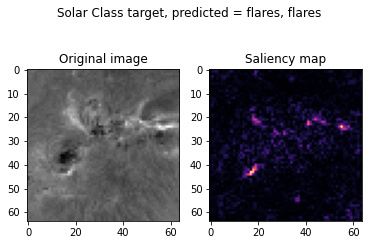

([0, 1, 2, 3, 4], <a list of 5 Text major ticklabel objects>)

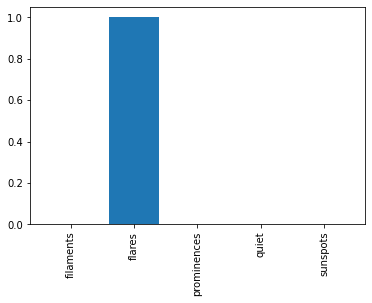

In [ ]:
import sys
classes = ['filaments', 'flares', 'prominences', 'quiet', 'sunspots']
b = np.linspace(-1,4,6)+0.5
h,_ = np.histogram(matt[:,0],bins = b)
print(h)
n = 1 ##class index
img = 0 ##image index of classes[n]
nn = np.where(matt[:,0]==n)[0][np.min([img,h[n]-1])]
#sys.setrecursionlimit(10000)
input_image = np.zeros((1,64,64,1))
input_image[0,:,:,0] = x_test[nn,:,:,0]
input_class = np.argmax(y_test[nn])
# Matplotlib subplot preparations
fig, axes = plt.subplots(1, 2)
# Generate visualization
visualization = visualize_saliency(model, layer_index, filter_indices=input_class, seed_input=input_image) ##saliency map for a particular input image and input class 
axes[0].imshow(input_image[0,:,:,0],cmap='gray') 
axes[0].set_title('Original image')
axes[1].imshow(visualization,cmap='magma')
#im = axes[1].imshow(np.log(visualization),cmap='magma')
#plt.colorbar(im, ax=axes[1])
axes[1].set_title('Saliency map')
fig.suptitle(f'Solar Class target, predicted = {classes[input_class]}, {classes[np.argmax(p[nn])]}')
plt.show()
plt.figure()
plt.bar(classes,p[nn])
plt.xticks(rotation = 90)

***Saliency Map for a false detection***

[176 270 304 242 326]
4


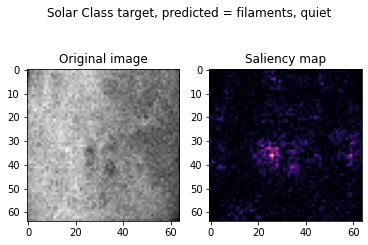

([0, 1, 2, 3, 4], <a list of 5 Text major ticklabel objects>)

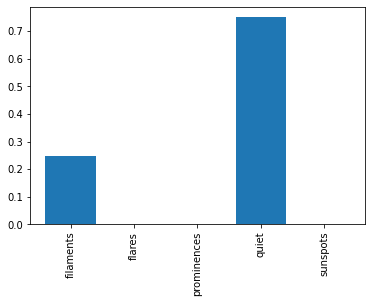

In [ ]:
classes = ['filaments', 'flares', 'prominences', 'quiet', 'sunspots']
b = np.linspace(-1,4,6)+0.5
h,_ = np.histogram(matt[:,0],bins = b)
print(h)
n = 0 ##class index

### detecting false detections where filaments get misclassified as quiet
false = []
for idx in np.where(matt[:,0]==n)[0]:
  if matt[idx,0]!=np.argmax(p[idx]):
    false.append(idx)
print(len(false))
nn = false[2]
#sys.setrecursionlimit(10000)
input_image = np.zeros((1,64,64,1))
input_image[0,:,:,0] = x_test[nn,:,:,0]
input_class = np.argmax(y_test[nn])
# Matplotlib subplot preparations
fig, axes = plt.subplots(1, 2)
# Generate visualization
visualization = visualize_saliency(model, layer_index, filter_indices=input_class, seed_input=input_image) ##saliency map for a particular input image and input class 
axes[0].imshow(input_image[0,:,:,0],cmap='gray') 
axes[0].set_title('Original image')
axes[1].imshow(visualization,cmap='magma')
#im = axes[1].imshow(np.log(visualization),cmap='magma')
#plt.colorbar(im, ax=axes[1])
axes[1].set_title('Saliency map')
fig.suptitle(f'Solar Class target, predicted = {classes[input_class]}, {classes[np.argmax(p[nn])]}')
plt.show()
plt.figure()
plt.bar(classes,p[nn])
plt.xticks(rotation = 90)

## **Conclusion**
1. Built a CNN model to classify 5 varieties of solar magnetic features
2. Performed tuning of the model by varying the nonlinear activation, learning rate, and batch size during training.
3. 'Elu' activation, a learning rate of 0.001 and batch size of 8 resulted in the best model after searching over 18 tuning parameter combinations
4. The model provided a test set accuracy of 99.54%
5. Only 6 images out of 1318 test images were misclassified
6. Visualisation of feature embedding acquired from the CNN model showed well-defined clusters
7. Visualising a feature space with each image pixel as a feature highlighted the difficulty in class separability and the effectiveness of deep learning in extracting meaningful features.
8. Saliency analysis depicted the regions that the model pays attention to while arriving at an inference. The saliency map visualized for a representative image with a flare ribbon feature clearly showed that the model was paying attention to the bright features. The saliency map for a 'filament' image example that the model misclassified as 'quiet' clearly highlighted the reason behind the inference. The filament (dark elongated) features were much less present than the quiet Sun background in the image and thus model found 'quiet' as the most prominent class followed by 'filament'.


## **Practical Use**
The trained model provides extremely fast inference (0.0012 seconds per image) with an accuracy of 99.54% and a balanced performance across the target classes. Thus this model has the potential to be incorporated for fast cataloguing of solar images in the data pipeline of a mission dedicated towards solar observation.

## **Future Research**
* The model being interpretable can be repurposed to perform hgiher label tasks in future such as feature segmentation, multi-label classification.
* It is possible that the model has potential to detect subclasses (e.g. single sunspot vs. multiple sunspots) as depicted by mutiple feature embedding clusters within different classes through the tSNE diagram. 